<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/Image/NeuN_Volumes_Cellpose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import matplotlib
import tifffile
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
import pandas as pd
from tqdm import tqdm
import scipy as sci
from cellpose import models
import statsmodels.api as sm
from statsmodels.formula.api import ols
import skimage
import urllib

f_name,_ = urllib.request.urlretrieve('https://raw.githubusercontent.com/dtabuena/Resources/main/Matplotlib_Config/Font_6_FastImport.ipynb','Font_6_FastImport.ipynb')
%run $f_name

In [41]:
"""
IMAGE MANIPULATION
"""
def dimension_to_front(data,dim_x):
    dim_list = list(np.arange(len(data.shape)))
    transpose = [dim_list[dim_x]] + dim_list[:dim_x] + dim_list[dim_x+1:]
    data_t = data.transpose(transpose)
    data_t =data_t.astype('float16')
    invs_transpose = list(np.argsort(transpose))
    return data_t, transpose, invs_transpose

def med_filt_stack(img,d):
    tiff_format = 'zcyx'
    color_dim = tiff_format.index('c')
    z_dim = tiff_format.index('z')
    color_dim=1
    z_dim=0
    for c in range(img.shape[color_dim]):
        for z in range(img.shape[z_dim]):
            img[z,c,:,:] = ski.filters.median(img[z,c,:,:],footprint=np.ones([d,d]))
    return img

def tiff_to_RGB_stack(tiff_data,rbg_channel_order = [1,0,0]):
    tiff_data = tiff_data[:,rbg_channel_order,:,:]
    tiff_data[:,1,:,:]=0
    rgb_stack = tiff_data.transpose([0,2,3,1])*225
    rgb_stack[rgb_stack<0]=0
    rgb_stack[rgb_stack>255]=255
    rgb_stack=rgb_stack.astype('uint8')
    return rgb_stack

def preprocess_image(tiff_data):
    tiff_data = ski.filters.gaussian(
        tiff_data, sigma=[1,1,1],
        mode='reflect',truncate = 4,
        channel_axis=1)
    tiff_data = med_filt_stack(tiff_data,5)
    tiff_data = norm_channels(tiff_data,'zcxy',clip=True,pct=[99,1])
    return tiff_data

def split_proj(tiff_data):
    print(tiff_data.shape)
    num_c = tiff_data.shape[3]
    fig,ax=plt.subplots(1,num_c,figsize=(num_c*1,1),dpi=300)
    colors = ['Reds','Greens','Blues','gray']
    for c in range(num_c):
        ax[c].imshow(np.max(tiff_data[:,:,:,c],axis=0), cmap=colors[c],vmin=0,vmax=255)
        ax[c].axis('off')
    plt.tight_layout()

def norm_channels(im_data,tiff_format,clip=False,pct=[99,1]):
    print(im_data.shape)
    color_dim = tiff_format.index('c')
    print('norm color dim =',color_dim)
    data_t, transpose, invs_transpose = dimension_to_front(im_data,color_dim)
    num_channels = data_t.shape[0]
    for c in np.arange(num_channels):
        c_data = data_t[c,:]
        (top,bot) = np.percentile(c_data.flatten(),pct)
        c_data = (c_data-bot)/(top-bot)
        data_t[c,:] = c_data
    im_data = data_t.transpose(invs_transpose)
    if clip:
        im_data[im_data>1]=1
        im_data[im_data<0]=0
    return im_data

In [42]:
"""
Model Building
"""
def fit_cell_model(img_rgb, cell_channel=1, nuclear_channel=0,channel_axis=3):
    cell_diam=40
    cell_model = models.Cellpose(model_type='cyto3',gpu=True)
    (cell_masks, flows, styles, diams) = cell_model.eval(
        img_rgb, channels=[cell_channel,nuclear_channel],
        channel_axis = channel_axis, diameter=cell_diam,
        do_3D=False, stitch_threshold=0.02)

    results_dict = {'cell_masks':cell_masks,
                'flows':flows,
                'styles':styles,
                'diams':diams,
                'cell_model':cell_model,}
    return results_dict

def fit_nuclear_model(img_rgb,nuclear_channel=3,channel_axis=3,nuc_diam = None):
    nuclear_model = models.Cellpose(model_type='nuclei',gpu=True)
    (nuclear_masks, _, _, _)=  nuclear_model.eval(
        img_rgb, channels=[nuclear_channel, 0],
        channel_axis = channel_axis, diameter=nuc_diam,
        do_3D=False, stitch_threshold=0.02,)
    return nuclear_masks

def save_masks(cell_masks,nuclear_masks,cell_masks_og,cell_layer_mask,curr_tif):
    image_name = os.path.splitext(os.path.basename(curr_tif))[0]
    np.save( image_name+'_cell_masks',cell_masks,allow_pickle=True)
    np.save( image_name+'_nuclear_masks',nuclear_masks,allow_pickle=True)
    np.save( image_name+'_cell_masks_og',cell_masks_og,allow_pickle=True)
    np.save( image_name+'_cell_layer_mask',cell_layer_mask,allow_pickle=True)

def load_masks(curr_tif):
    image_name = os.path.splitext(os.path.basename(curr_tif))[0]
    cell_masks = np.load( image_name+'_cell_masks.npy')
    nuclear_masks = np.load( image_name+'_nuclear_masks.npy')
    cell_masks_og = np.load( image_name+'_cell_masks_og.npy')
    cell_layer_mask = np.load( image_name+'_cell_layer_mask.npy')
    return (cell_masks,nuclear_masks,cell_masks_og,cell_layer_mask)

In [43]:
"""
Validate Nuc ROI's
"""
def quant_entities(entity_mask,voxel_dim_um):
    entity_mask_f = entity_mask.flatten()
    ent_ids = np.unique(entity_mask_f)
    bins = np.insert(ent_ids+0.5, 0, -0.5, axis=0)
    (sizes_px, edges) = np.histogram(entity_mask_f,bins=bins)
    sizes_um3 = sizes_px*voxel_vol_um3
    entity_df = pd.DataFrame({'ids':ent_ids[1:],'sizes_px':sizes_px[1:],
                            'sizes_um3':sizes_um3[1:]}).set_index('ids')
    entity_df =  analyze_ferrets(entity_df,entity_mask,voxel_dim_um)

    return entity_df

def qc_nuc_mask(nuclear_masks, voxel_dim_um):
    entity_df = quant_entities(nuclear_masks, voxel_dim_um)

    min_fer_thresh_um = 1*np.max(voxel_dim_um)
    entity_df = entity_df[entity_df['min_fer']>= min_fer_thresh_um]
    # entity_df = entity_df[entity_df['pct_fill']>=.4]
    new_mask = np.zeros_like(nuclear_masks)
    for ent in entity_df.index:
        new_mask[nuclear_masks==ent] = ent
    return new_mask, entity_df

In [313]:
"""
Analyze Models
"""
def find_child_nucleii(cell_masks,nuclear_masks,cell_df):
    cell_df['nucleii']=np.nan
    cell_df['nuc_count']=np.nan
    cell_df['nucleii']=cell_df['nucleii'].astype(object)
    for cell in cell_df.index:
        cell_nuc_overlap = nuclear_masks [cell_masks==cell]
        cell_nuc_overlap=[n for n in cell_nuc_overlap if n>0]
        cell_df.at[cell,'nucleii'] = np.unique(cell_nuc_overlap)
        cell_df.at[cell,'nuc_count'] = cell_df.at[cell,'nucleii'].size
    return cell_df


def analyze_ferrets(cell_df,cell_masks,voxel_dim_um):
    cell_df['feret_d']=np.nan
    cell_df['feret_d']= cell_df['feret_d'].astype(object)
    for id in cell_df.index:
        cell_df.at[id,'feret_d'] = nd_feret(cell_masks==id,zxy_scalars=voxel_dim_um[[2,0,1]])

    ferrets = cell_df['feret_d'].to_numpy()
    ferrets = np.stack(ferrets,axis=0)
    cell_df['feret_z'] = ferrets[:,0]
    cell_df['feret_x'] = ferrets[:,1]
    cell_df['feret_y'] = ferrets[:,2]
    cell_df['min_fer'] = np.min(ferrets,axis=1)
    cell_df['box_vol'] = np.prod(ferrets,axis=1)
    cell_df['pct_fill'] = cell_df['sizes_um3']/cell_df['box_vol']

    return cell_df

def nd_feret(mask,zxy_scalars=None):
    if zxy_scalars is None:
        scalars=np.ones_like(mask.shape)
    n_coords=np.where(mask)
    feret_diams = list()
    for s, coord in zip(zxy_scalars,n_coords):
        diam = np.max(coord)-np.min(coord)+1
        feret_diams.append(diam*s)
    return np.asarray(feret_diams)

def trim_edge_bound(masks):
    masks_og = masks.copy()
    planes = [masks[0,:,:],
              masks[-1,:,:],
              masks[:,0,:],
              masks[:,-1,:],
              masks[:,:,0],
              masks[:,:,-1]]
    for p in planes:
        del_ids = np.unique(p)
        for id in del_ids:
            masks[masks==id] = 0
    return masks, masks_og


def find_cell_nuclei(cells_df,cell_masks,nuclear_masks):
    cells_df['nuclei_ids'] = np.nan
    cells_df['nuclei_ids']=cells_df['nuclei_ids'].astype(object)
    for cell in cells_df.index:
        nuclei_ids = nuclear_masks[cell_masks==cell]
        nuclei_ids = np.unique(nuclei_ids)
        nuclei_ids = [n for n in nuclei_ids if n>0]
        cells_df.at[cell,'nuclei_ids'] = nuclei_ids
    cells_df['nuc_count'] = [len(nucs) for nucs in cells_df['nuclei_ids']]
    return cells_df

In [113]:
"""
NeuN vol divided by Num Nuclei
"""
def calc_neun_layer_mask(tiff_data_raw,thresh=0.2):
    max_neun = np.max(tiff_data_raw[:,1,:,:],axis=0)
    neun_z = (max_neun - np.mean(max_neun)) / np.std(max_neun)
    chunks = ski.measure.label(neun_z>thresh)*1.0
    size,label=np.histogram(chunks,bins=np.unique(chunks))
    label=label[1:-1]
    size=size[1:]
    chunk_sizes ={l:s for l,s in zip(label,size)}
    biggest = label[size == np.nanmax(size)]
    neun_layer_mask = chunks==biggest
    neun_layer_mask_4d=np.stack([neun_layer_mask]*tiff_data_raw.shape[1],axis=0)
    neun_layer_mask_4d=np.stack([neun_layer_mask_4d]*tiff_data_raw.shape[0],axis=0)
    tiff_data_masked = tiff_data_raw*neun_layer_mask_4d
    return neun_layer_mask, tiff_data_masked

def mean_volumes(nuclear_masks,tiff_data_raw,cell_layer_mask):
    # plt.imshow(np.sum(nuclear_masks,axis=0))

    neun = tiff_data_raw[:,1,:,:]
    neun_z = (neun - np.nanmean(neun)) / np.nanstd(neun)
    neun_pos = neun_z >0.5
    neun_pos_masked = neun_pos *  np.stack([nan_cell_layer_mask]*neun.shape[0],axis=0)

    num_nuclei = np.max(nuclear_masks)

    neun_vox_vol = np.nansum(neun_pos_masked)
    voxel_dim_um=np.array([0.3977476,0.3977476,0.5])
    voxel_vol_um3 = np.prod(voxel_dim_um)
    neun_vox_vol_um3 = neun_vox_vol * voxel_vol_um3
    mean_vol_um3 = neun_vox_vol_um3/num_nuclei
    return (mean_vol_um3, num_nuclei,neun_vox_vol_um3)


def np_to_rgb(raw,channel_bal=[1,1,1]):
    norm = (raw - np.min(raw))/(np.max(raw) - np.min(raw))
    rgb = np.stack( [norm*channel_bal[0],
                     norm*channel_bal[1],
                     norm*channel_bal[2],
                     ],axis=-1)
    return rgb

In [66]:
"""
Generate MASKS
"""

def generate_masks_from_file(curr_tif,voxel_dim_um):
    tiff_data_raw = tifffile.imread(curr_tif)
    cell_layer_mask, tiff_data_masked = calc_neun_layer_mask(tiff_data_raw,thresh=0.2)
    tiff_data = preprocess_image(tiff_data_masked)
    rgb_stack = tiff_to_RGB_stack(tiff_data)
    split_proj(rgb_stack)

    nuclear_masks = fit_nuclear_model(rgb_stack,nuclear_channel=3,channel_axis=3)
    nuclear_masks,_ = qc_nuc_mask(nuclear_masks,voxel_dim_um)

    results_dict = fit_cell_model(rgb_stack,channel_axis=3)
    cell_masks = results_dict['cell_masks']
    cell_masks, cell_masks_og = trim_edge_bound(cell_masks)
    save_masks(cell_masks,nuclear_masks,cell_masks_og,cell_layer_mask,curr_tif)

In [118]:
"""
POPULATE TIFF LIST
"""
source_directory = 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF/Cell_layer'
os.chdir(source_directory)
my_tiffs = list()
for rt,dirs,file_list in os.walk(source_directory):
    for file in file_list:
        if 'tif' in file:
            my_tiffs.append(os.path.join(rt,file))

voxel_dim_um=np.array([0.3977476,0.3977476,0.5])
voxel_vol_um3 = np.prod(voxel_dim_um)

age_dict={
    'DAPI-NeuN_E3-E_20x2_1.tif': 10,
    'DAPI-NeuN_E3-E_20x2_2.tif': 10,
    'DAPI-NeuN_E3-F_20x2_1.tif': 10,
    'DAPI-NeuN_E3-F_20x2_2.tif': 10,
    'DAPI-NeuN_E3-G_20x2_1.tif': 10,
    'DAPI-NeuN_E3-G_20x2_2.tif': 10,
    'DAPI-NeuN_E3-H_20x2_1.tif': 5,
    'DAPI-NeuN_E3-H_20x2_2.tif': 5,
    'DAPI-NeuN_E3-I_20x2_1.tif': 5,
    'DAPI-NeuN_E3-I_20x2_2.tif': 5,
    'DAPI-NeuN_E3-J_20x2_1.tif': 5,
    'DAPI-NeuN_E3-J_20x2_2.tif': 5,
    'DAPI-NeuN_E4-F_20x2_1.tif': 10,
    'DAPI-NeuN_E4-F_20x2_2.tif': 10,
    'DAPI-NeuN_E4-G_20x2_1.tif': 10,
    'DAPI-NeuN_E4-G_20x2_2.tif': 10,
    'DAPI-NeuN_E4-H_20x2_1.tif': 10,
    'DAPI-NeuN_E4-H_20x2_2.tif': 10,
    'DAPI-NeuN_E4-K_20x2_1.tif': 5,
    'DAPI-NeuN_E4-K_20x2_2.tif': 5,
    'DAPI-NeuN_E4-L_20x2_1.tif': 5,
    'DAPI-NeuN_E4-L_20x2_2.tif': 5,
    'DAPI-NeuN_E4-M_20x2_1.tif': 5,
    'DAPI-NeuN_E4-M_20x2_2.tif': 5,}

my_tiffs = [t for t in my_tiffs if 'DAPI' in t]


In [448]:
def roi_plot(tiff_data_raw,nuclear_masks,cell_layer_mask,sample_z):
    roi_fig,ax=plt.subplots(2,2,figsize=(1.5,1.5))
    ax=ax.flatten()
    for a in ax: a.set_axis_off()

    dapi_rgb = np_to_rgb(tiff_data_raw[sample_z,0,:,:],channel_bal=[0,0,1])*6
    neun_rgb = np_to_rgb(tiff_data_raw[sample_z,1,:,:],channel_bal=[1,1,1])
    merge = dapi_rgb+neun_rgb

    ax[2].imshow(dapi_rgb)
    ax[1].imshow(neun_rgb)
    ax[0].imshow(merge)
    ax[3].imshow(merge * np.stack([cell_layer_mask]*3,axis=-1))


    nuc_edges = ski.filters.sobel(nuclear_masks[sample_z,:,:])>0.0002

    ax[3].contour(np.mean(nuclear_masks,axis=0),linewidths=.2,cmap='hsv')
    ax[2].contour(np.mean(nuclear_masks,axis=0),linewidths=.2,cmap='hsv')

    ax[3].contour(cell_layer_mask*5,linewidths=.2,cmap='hot')
    ax[1].contour(cell_layer_mask*5,linewidths=.2,cmap='hot')
    plt.tight_layout()
    plt.show()
    return roi_fig



In [527]:
def roi_plot_inds(tiff_data_raw,nuclear_masks,cell_layer_mask,sample_z):


    dapi_rgb = np_to_rgb(tiff_data_raw[sample_z,0,:,:],channel_bal=[0,0,1])*6
    neun_rgb = np_to_rgb(tiff_data_raw[sample_z,1,:,:],channel_bal=[1,1,1])
    merge = dapi_rgb+neun_rgb
    nuc_edges = ski.filters.sobel(nuclear_masks[sample_z,:,:])>0.0002

    fig_merge,ax = plt.subplots(figsize=(2,2))
    ax.imshow(merge)

    y0 = tiff_data_raw.shape[2]*0.9
    x0 = tiff_data_raw.shape[2]*0.1
    um_bar_len = 60
    pxl_bar_len = um_bar_len * 1 / voxel_dim_um[0]
    ax.plot( [x0,x0+pxl_bar_len],[y0,y0],color='w',linewidth=3)
    ax.set_axis_off()

    fig_dapi_rgb,ax = plt.subplots(figsize=(2,2))
    ax.imshow(dapi_rgb)
    ax.contour(np.mean(nuclear_masks,axis=0),linewidths=.2,cmap='hsv')
    ax.set_axis_off()

    fig_neun_rgb,ax = plt.subplots(figsize=(2,2))
    ax.imshow(neun_rgb)
    ax.contour(cell_layer_mask*5,linewidths=.2,cmap='hot')
    ax.set_axis_off()


    fig_rois,ax = plt.subplots(figsize=(2,2))
    ax.imshow(neun_rgb)
    ax.imshow(merge * np.stack([cell_layer_mask]*3,axis=-1))
    ax.contour(np.mean(nuclear_masks,axis=0),linewidths=.2,cmap='hsv')
    ax.contour(cell_layer_mask*5,linewidths=.2,cmap='hot')
    ax.set_axis_off()


    return {"fig_merge":fig_merge,
            "fig_dapi_rgb":fig_dapi_rgb,
            "fig_neun_rgb":fig_neun_rgb,
            "fig_rois":fig_rois}


In [512]:
# tiff_data_raw.shape
y0 = tiff_data_raw.shape[2]*0.1
x0 = tiff_data_raw.shape[2]*0.1
um_bar_len = 30
pxl_bar_len = um_bar_len * 1 / voxel_dim_um[0]
print(pxl_bar_len)

75.42471657905668


In [ ]:
"""
Process Masks
"""
sample_z = 15
for curr_tif in my_tiffs:
    # generate_masks_from_file(curr_tif,voxel_dim_um)
    image_name = os.path.splitext(os.path.basename(curr_tif))[0]
    tiff_data_raw = tifffile.imread(curr_tif)
    cell_masks,nuclear_masks,cell_masks_og,cell_layer_mask = load_masks(curr_tif)
    # roi_fig = roi_plot(tiff_data_raw,nuclear_masks,cell_layer_mask,sample_z )
    # roi_fig.savefig(f'{image_name}_roi_fig.svg')

    panel_dict = roi_plot_inds(tiff_data_raw,nuclear_masks,cell_layer_mask,sample_z)
    for panel_type, panel in panel_dict.items():
        panel.savefig(f'{image_name}_{panel_type}_fig.svg',bbox_inches='tight')





In [447]:
"""
ANALYZE VOLUMES
"""

"""
Mean Volumes Based On NeuN Mask
"""
mean_vols_df = pd.DataFrame({'tiffs':my_tiffs}).set_index('tiffs')
mean_vols_df['geno'] = ['E4' if 'E4' in t else 'E3' for t in mean_vols_df.index]
mean_vols_df['age'] = [  age_dict[os.path.basename(t)]  for t in mean_vols_df.index]
mean_vols_df['gene_emb'] =[('E4' in v) for v in mean_vols_df['geno'].values]
for a in ['num_nuclei','neun_vox_vol_um3','mean_vol_um3']:
    mean_vols_df[a]=np.nan
    mean_vols_df[a]=mean_vols_df[a].astype('object')

for curr_tif in tqdm(my_tiffs):
    tiff_data_raw = tifffile.imread(curr_tif)
    cell_masks,nuclear_masks,cell_masks_og,cell_layer_mask = load_masks(curr_tif)
    mean_vol_um3, num_nuclei, neun_vox_vol_um3 = mean_volumes(nuclear_masks,tiff_data_raw,cell_layer_mask)
    mean_vols_df.at[curr_tif,'mean_vol_um3'] = mean_vol_um3
    mean_vols_df.at[curr_tif,'num_nuclei'] = num_nuclei
    mean_vols_df.at[curr_tif,'neun_vox_vol_um3'] = neun_vox_vol_um3
mean_vols_df['age'] = pd.to_numeric(mean_vols_df['age'])
mean_vols_df['mean_vol_um3'] = pd.to_numeric(mean_vols_df['mean_vol_um3'])
display(mean_vols_df.head(30))


"""
N = FOV STATS
"""
model = ols("mean_vol_um3 ~ gene_emb + age + gene_emb:age",data = mean_vols_df).fit()
anova_table=sm.stats.anova_lm(model,typ=2)
display(anova_table)


mean_vols_df.to_csv('mean_vols_df.csv')

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:21<00:00,  1.13it/s]


,geno,age,gene_emb,num_nuclei,neun_vox_vol_um3,mean_vol_um3
tiffs,,,,,,
C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF/Cell_layer\DAPI-NeuN_E3-E_20x2_1.tif,E3,10,False,350,139597.908766,398.851168
C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF/Cell_layer\DAPI-NeuN_E3-E_20x2_2.tif,E3,10,False,332,150438.384338,453.127664
C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF/Cell_layer\DAPI-NeuN_E3-F_20x2_1.tif,E3,10,False,340,115041.298904,338.356761
C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF/Cell_layer\DAPI-NeuN_E3-F_20x2_2.tif,E3,10,False,284,161547.488865,568.829186
C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF/Cell_layer\DAPI-NeuN_E3-G_20x2_1.tif,E3,10,False,344,137688.554909,400.257427
C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF/Cell_layer\DAPI-NeuN_E3-G_20x2_2.tif,E3,10,False,350,152333.499912,435.238571
C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF/Cell_layer\DAPI-NeuN_E3-H_20x2_1.tif,E3,5,False,302,132903.305029,440.077169
C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF/Cell_layer\DAPI-NeuN_E3-H_20x2_2.tif,E3,5,False,293,138173.210269,471.580922
C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF/Cell_layer\DAPI-NeuN_E3-I_20x2_1.tif,E3,5,False,281,130217.094588,463.406031


,sum_sq,df,F,PR(>F)
gene_emb,19334.060486,1.0,1.998492,0.172833
age,3204.458126,1.0,0.331233,0.571353
gene_emb:age,208.735479,1.0,0.021576,0.884691
Residual,193486.505680,20.0,NaN,NaN


In [446]:
"""
Consolidated FOVs; N = Animal
"""
animal_tags = [os.path.basename(t)[:-5] for t in mean_vols_df.index]
animal_tags = sorted(list(set(animal_tags)))


df_list = list()
for animal in animal_tags:
    df_pair=mean_vols_df[ [animal in t for t in mean_vols_df.index]    ]
    df_consold = df_pair.iloc[0].copy()
    df_consold['num_nuclei'] = np.sum(df_pair['num_nuclei'])
    df_consold['neun_vox_vol_um3'] = np.sum(df_pair['neun_vox_vol_um3'])
    df_consold['mean_vol_um3'] = df_consold['neun_vox_vol_um3'] / df_consold['num_nuclei']
    df_list.append(pd.DataFrame(df_consold).transpose())
mean_vols_df_c = pd.concat(df_list)

mean_vols_df_c['gene_enc'] =[('E4' in v) for v in mean_vols_df_c['geno'].values]
mean_vols_df_c['age'] = pd.to_numeric(mean_vols_df_c['age'])
mean_vols_df_c['mean_vol_um3'] = pd.to_numeric(mean_vols_df_c['mean_vol_um3'])
# display(mean_vols_df_c)


"""
STATS N=Animal
"""

mean_vols_df_c.to_csv('mean_vols_df_c.csv')
model = ols("mean_vol_um3 ~ gene_enc + age + gene_enc:age",data = mean_vols_df_c).fit()
anova_table=sm.stats.anova_lm(model,typ=2)
display(anova_table)

,sum_sq,df,F,PR(>F)
gene_enc,9589.433643,1.0,1.650905,0.234787
age,1493.559340,1.0,0.257129,0.625778
gene_enc:age,55.608416,1.0,0.009573,0.924463
Residual,46468.728694,8.0,NaN,NaN


In [142]:
"""
COMPARE CAPACITANCE
"""
def sphere_rad2sa(r):
    return 4*np.pi*r**2

def sphere_sa2rad(sa):
    return np.sqrt(sa/4/np.pi)

def sphere_rad2vol(r):
    return 4/3*np.pi*r**3

def sphere_vol2rad(vol):
    return (vol*3/4/np.pi)**(1/3)



399.99999999999983

In [ ]:
"""
0.9 microF/cm(2)
"""

In [445]:
cell_capacitances = pd.read_csv('./Cell_Capacitances.csv')
# display(cell_capacitances.head(6))
global_std = np.nanstd(cell_capacitances.values)
print(global_std,'global_cap_std')

global_vol_std = np.nanstd(sphere_rad2vol(sphere_sa2rad(cell_capacitances.values)))
print(global_vol_std,'global_vol_std')

effect_magnitude = np.nanmean(cell_capacitances['apoE3-KI 7-9mo'].values) - np.nanmean(cell_capacitances['apoE4-KI 7-9mo'].values)
print(effect_magnitude,'effect_magnitude')

sa_mean_1 = np.nanmean(cell_capacitances['apoE3-KI 7-9mo'].values)
sa_mean_2 = np.nanmean(cell_capacitances['apoE4-KI 7-9mo'].values)
expected_vol_1 = sphere_rad2vol(sphere_sa2rad(sa_mean_1))
expected_vol_2 = sphere_rad2vol(sphere_sa2rad(sa_mean_2))

print(sa_mean_1, sa_mean_2, 1-sa_mean_2/sa_mean_1)
print(expected_vol_1, expected_vol_2, 1-expected_vol_2/expected_vol_1)


mc=np.nanmean(cell_capacitances.values)
sc=np.nanstd(cell_capacitances.values)
def z_cap(c,mc,sc):
    return (c-m) / s

mv=np.nanmean(cell_capacitances.values)
sv=np.nanstd(cell_capacitances.values)
def z_cap(v,mv,sv):
    return (v-m) / s




41.77548540647364 global_cap_std
94.82511173122731 global_vol_std
37.52290810810811 effect_magnitude
207.0981081081081 169.5752 0.181184214819194
328.2269569855838 243.1943920229191 0.25906636597919486


In [443]:
obs_vols = mean_vols_df['mean_vol_um3'].values
print('mean obesrved volume', np.mean(obs_vols))
print('mean obesrved std',np.std(obs_vols))
f" 1SD = {np.std(obs_vols)/np.mean(obs_vols)*100} % of mean"


mean obesrved volume 412.66654408854953
mean obesrved std 94.91965018085774


' 1SD = 23.001537570850424 % of mean'

In [208]:
def sphere_rad2pf(r_um):
    r_cm = r_um/1000
    sa_cm = 4*np.pi*r**2
    sa_pf=900000*sa_cm
    return sa_pf

def sphere_sa2rad(sa_pf):
    sa_cm = sa_pf/900000
    r_cm = np.sqrt(sa_cm/4/np.pi)
    r_um = r_cm*1000
    return r_um

def sphere_rad2vol(r_um):
    return 4/3*np.pi*r_um**3

def sphere_vol2rad(vol_um):
    return (vol_um*3/4/np.pi)**(1/3)





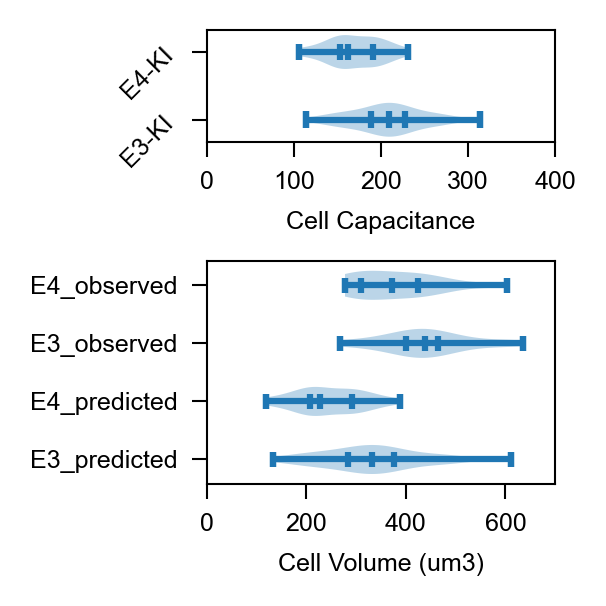

In [295]:
e3_rads = sphere_sa2rad(cell_capacitances['apoE3-KI 7-9mo'].values)
e3_pf =cell_capacitances['apoE3-KI 7-9mo'].values
e3_pf = e3_pf[np.isfinite(e3_pf)]
pred_e3_vol = sphere_rad2vol(e3_rads)
# print(pred_e3_vol)


e4_rads = sphere_sa2rad(cell_capacitances['apoE4-KI 7-9mo'].values)
e4_pf =cell_capacitances['apoE4-KI 7-9mo'].values
e4_pf = e4_pf[np.isfinite(e4_pf)]
pred_e4_vol = sphere_rad2vol(e4_rads)
pred_e4_vol=pred_e4_vol[np.isfinite(pred_e4_vol)]
# print(pred_e4_vol)
bins=np.arange(0,800,50)
fig,ax=plt.subplots(2,1,figsize=(2,2),height_ratios=[1,2])
ax=ax.flatten()

obs_e3 = mean_vols_df['mean_vol_um3'][~mean_vols_df['gene_emb']]
obs_e4 = mean_vols_df['mean_vol_um3'][mean_vols_df['gene_emb']]

# ax[0].hist(pred_e3_vol,bins=bins,histtype='step',label='e3_pred')
# ax[0].hist(pred_e4_vol,bins=bins,histtype='step',label='e4_pred')
# ax[0].hist(obs_e3,bins=bins,histtype='step',label='e3_obs')
# ax[0].hist(obs_e4,bins=bins,histtype='step',label='e4_obs')
# ax[0].set_xlabel('Cell Volume (um3)')
# ax[0].set_ylabel('Bin Count (cells)')
# ax[0].legend()


quantiles=[[0,0.25,0.5,0.75,1] for n in range(4)]
ax[1].violinplot([pred_e3_vol,pred_e4_vol,obs_e3,obs_e4],quantiles=quantiles,vert=False)
ax[1].set_xlim([0,700])
ax[1].set_yticks([1,2,3,4],['E3_predicted','E4_predicted','E3_observed','E4_observed'])
ax[1].set_xlabel('Cell Volume (um3)')

quantiles=[[0,0.25,0.5,0.75,1] for n in range(2)]
ax[0].violinplot([e3_pf,e4_pf],quantiles=quantiles,vert=False)
ax[0].set_xlim([0,400])
ax[0].set_yticks([1,2],['E3-KI','E4-KI'],rotation=45)
ax[0].set_xlabel('Cell Capacitance')
plt.tight_layout()



In [288]:
""" Imaging Data Export """
pd.DataFrame(obs_e3).to_csv('E3_observed.csv')
pd.DataFrame(obs_e4).to_csv('E4_observed.csv')
pd.DataFrame(pred_e3_vol).to_csv('E3_predicted.csv')
pd.DataFrame(pred_e4_vol).to_csv('E4_predicted.csv')
pd.DataFrame(e3_pf).to_csv('e3_pf.csv')
pd.DataFrame(e4_pf).to_csv('e4_pf.csv')

In [ ]:
""" 1. Read in Masks """
""" 2. Parse Nuclear Masks """
""" 3. Parse Cell Masks """
""" 4. Trim Cells
        edge cells
        cell layer
        sphericity """
""" 5. Summaryize in CDF """
""" 6. KS-Test """
""" 7. Permutation Test """


DAPI-NeuN_E3-E_20x2_1


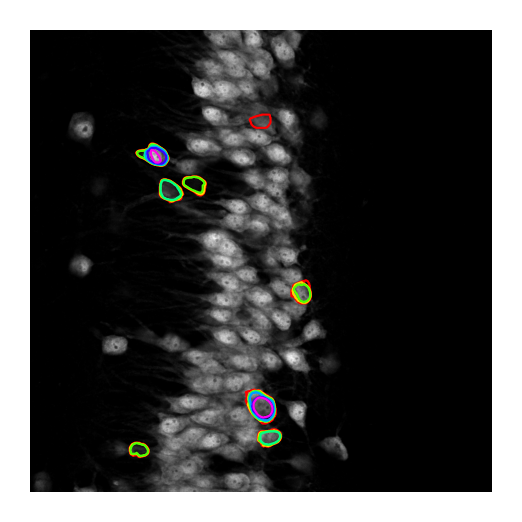

DAPI-NeuN_E3-E_20x2_2


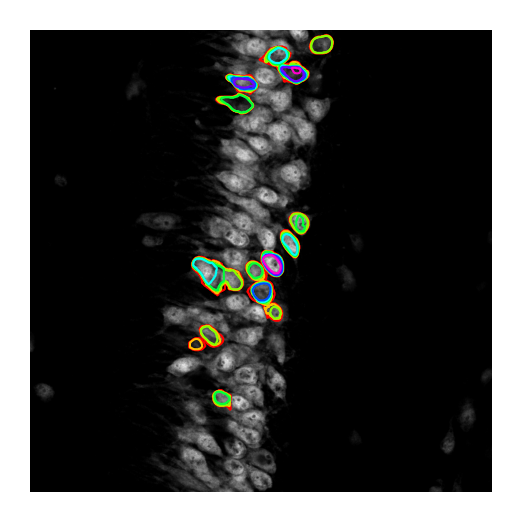

DAPI-NeuN_E3-F_20x2_1


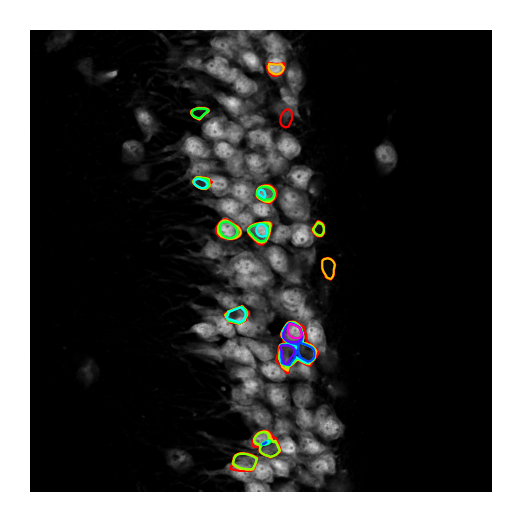

DAPI-NeuN_E3-F_20x2_2


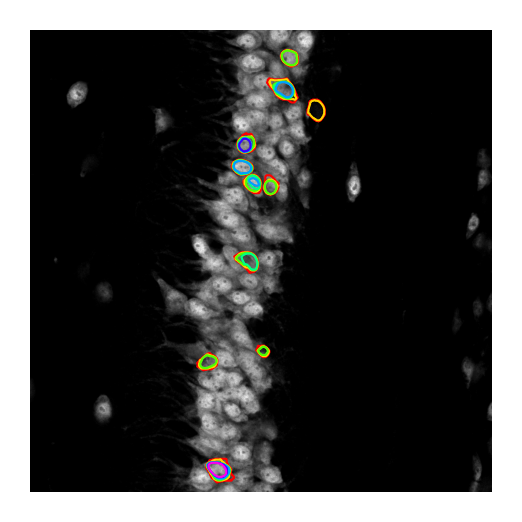

DAPI-NeuN_E3-G_20x2_1


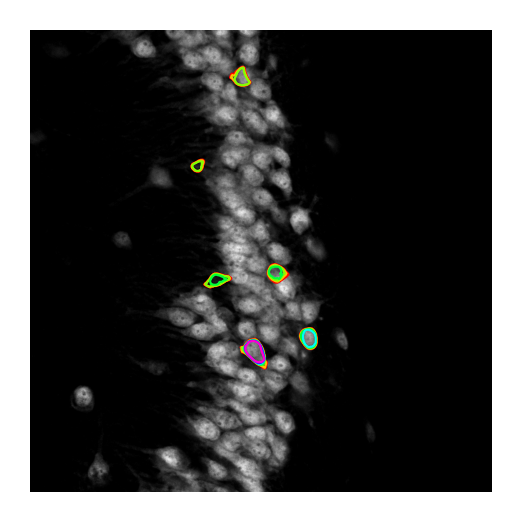

DAPI-NeuN_E3-G_20x2_2


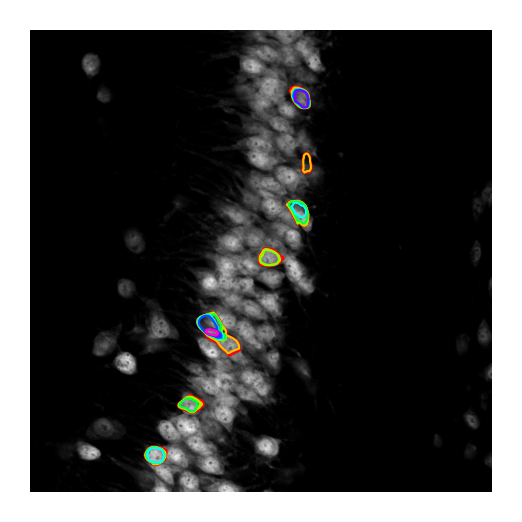

DAPI-NeuN_E3-H_20x2_1


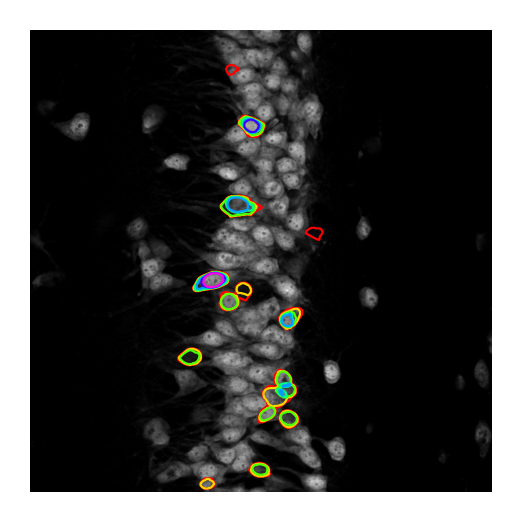

DAPI-NeuN_E3-H_20x2_2


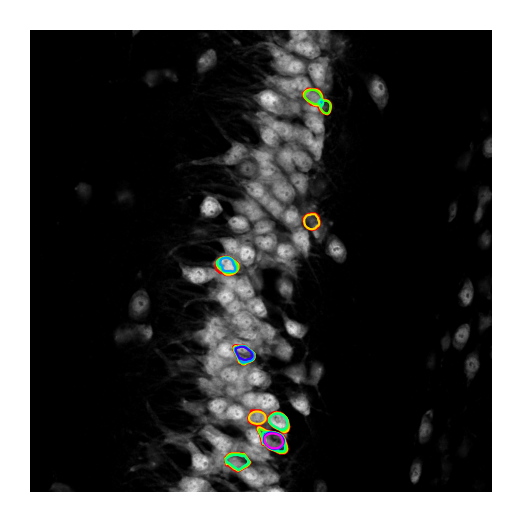

DAPI-NeuN_E3-I_20x2_1


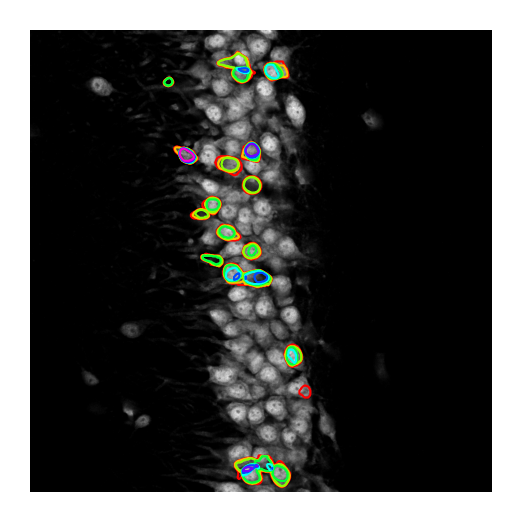

DAPI-NeuN_E3-I_20x2_2


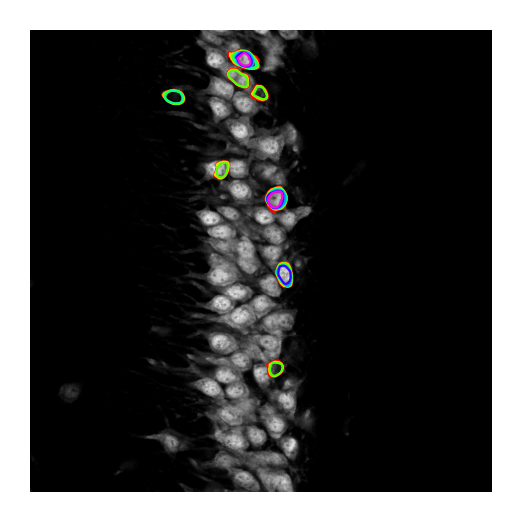

DAPI-NeuN_E3-J_20x2_1


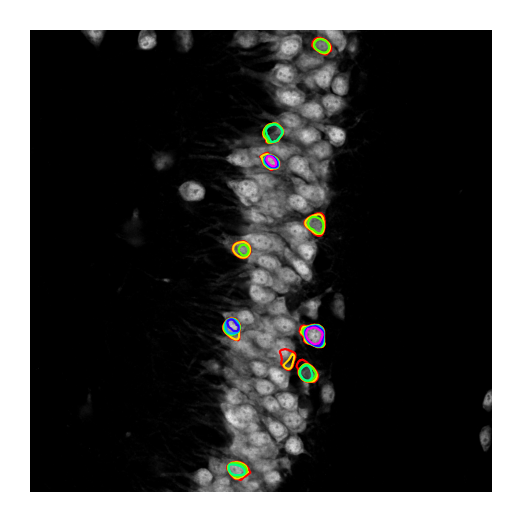

DAPI-NeuN_E3-J_20x2_2


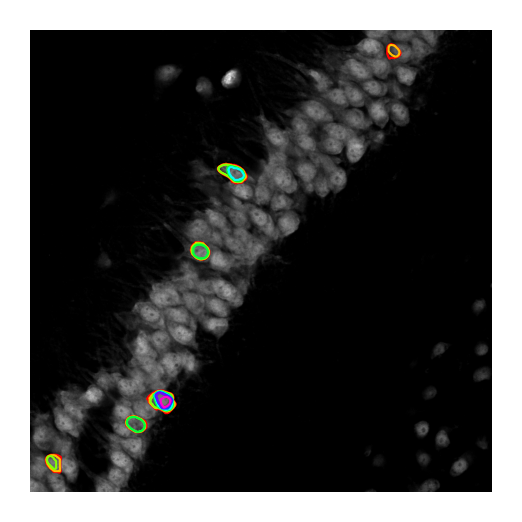

DAPI-NeuN_E4-F_20x2_1


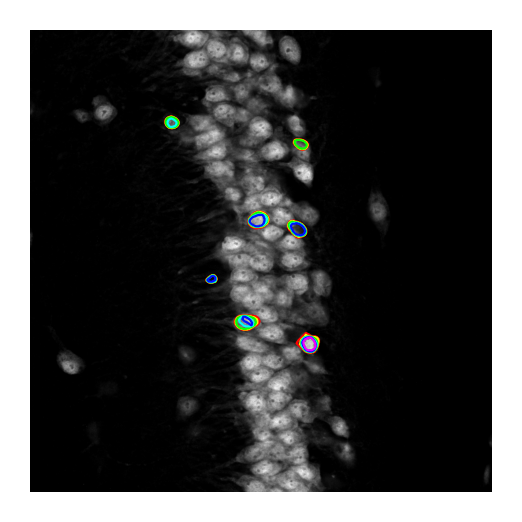

DAPI-NeuN_E4-F_20x2_2


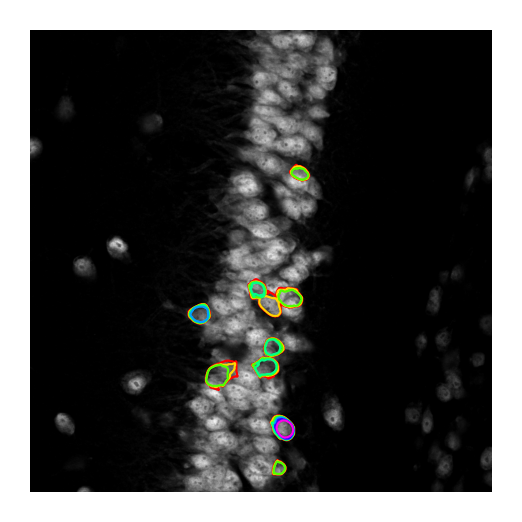

DAPI-NeuN_E4-G_20x2_1


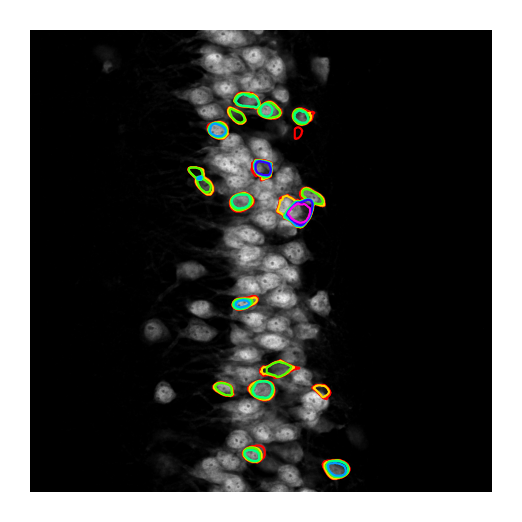

DAPI-NeuN_E4-G_20x2_2


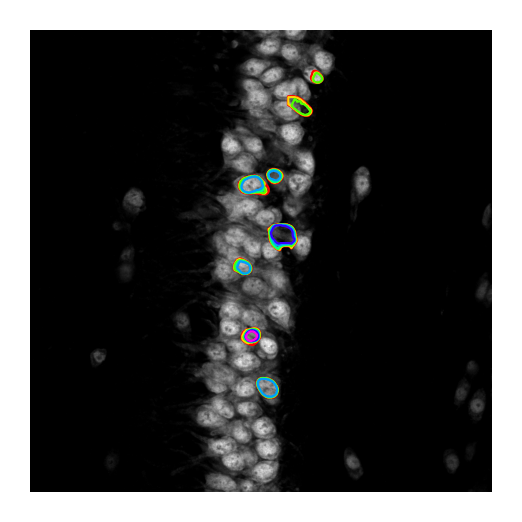

DAPI-NeuN_E4-H_20x2_1


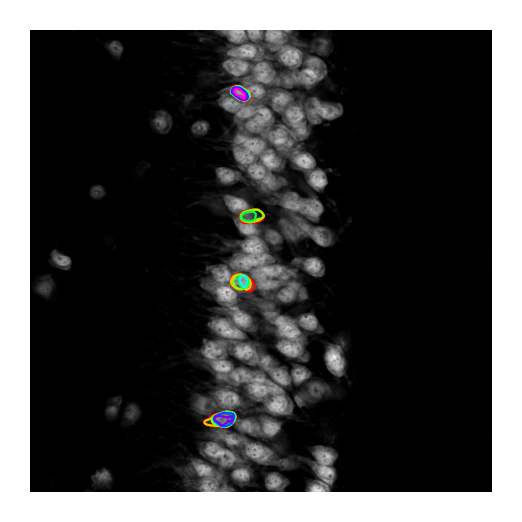

DAPI-NeuN_E4-H_20x2_2


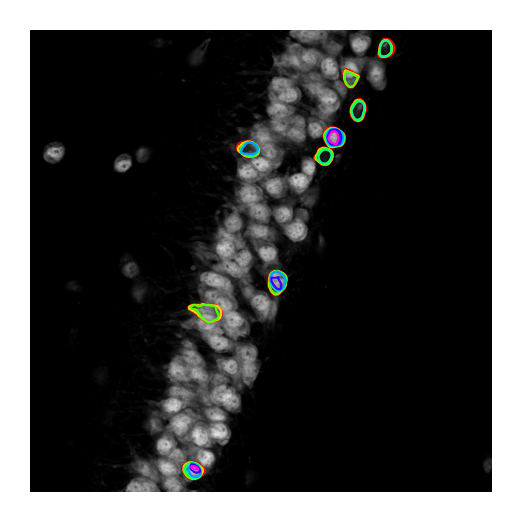

DAPI-NeuN_E4-K_20x2_1


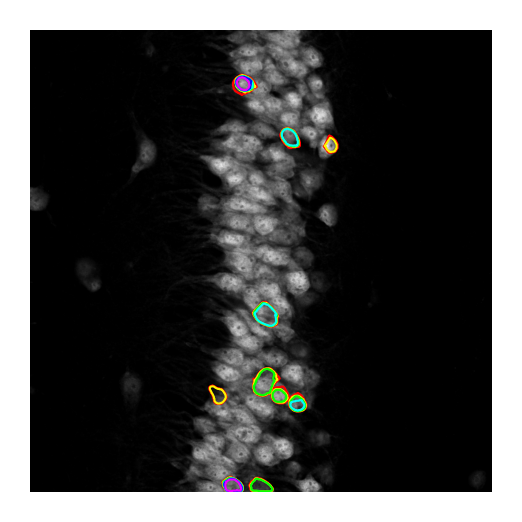

DAPI-NeuN_E4-K_20x2_2


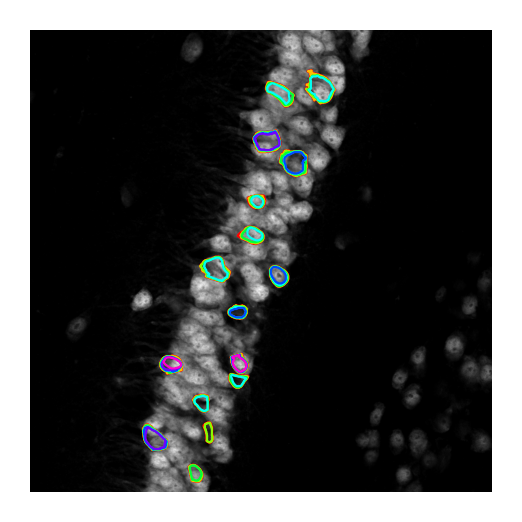

DAPI-NeuN_E4-L_20x2_1


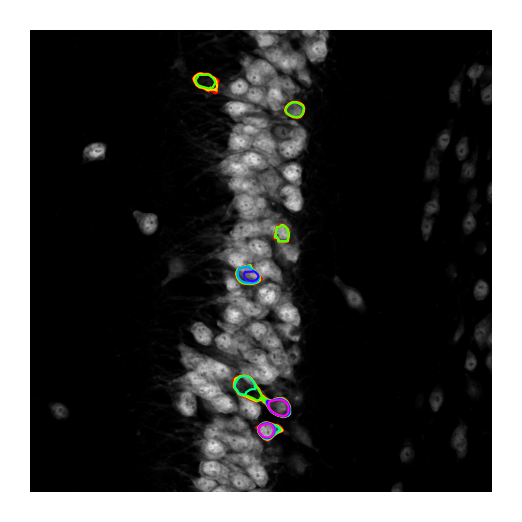

DAPI-NeuN_E4-L_20x2_2


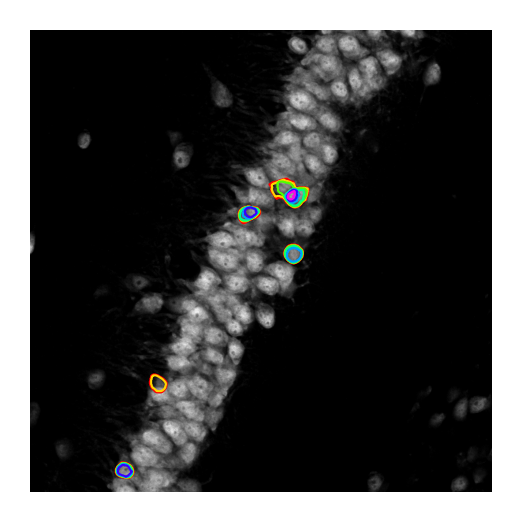

DAPI-NeuN_E4-M_20x2_1


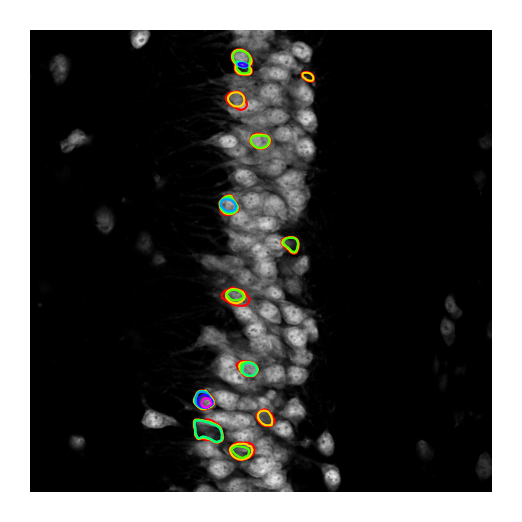

DAPI-NeuN_E4-M_20x2_2


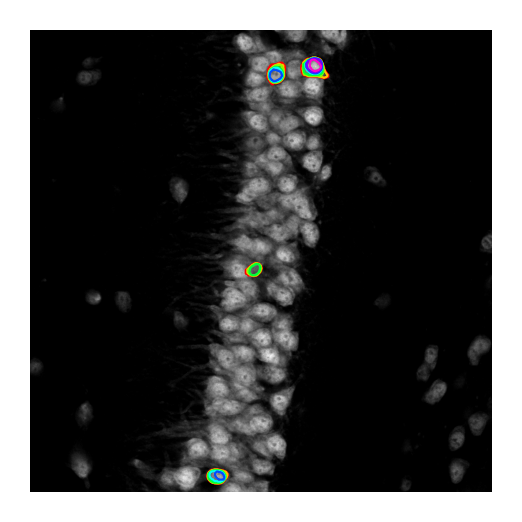

In [489]:
vols=list()
for curr_tif in my_tiffs:
    """ 1. Read in Masks """
    cell_masks,nuclear_masks,cell_masks_og,cell_layer_mask = load_masks(curr_tif)

    """ 2. Parse Nuclear Masks """
    nuclear_df = quant_entities(nuclear_masks,voxel_dim_um)

    """ 3. Parse Cell Masks """
    cell_masks, cell_masks_og = trim_edge_bound(cell_masks)
    cells_df = quant_entities(cell_masks,voxel_dim_um)
    cells_df = find_cell_nuclei(cells_df,cell_masks,nuclear_masks)

    """ 4. Trim Cells  """
    cells_df = cells_df[cells_df['nuc_count']<2]
    cells_df = cells_df[cells_df['pct_fill']>.4]
    cells_df = cells_df[cells_df['min_fer']>1]
    vols.append(cells_df['sizes_um3'].values)

    """ 4.5 Plot QC'd Mask"""
    cell_masks_qc = np.zeros_like(cell_masks)
    for id in cells_df.index:
        cell_masks_qc[cell_masks==id]=id

    sample_z= 15
    fig_good_vols,ax = plt.subplots(figsize=(2,2))
    image_name = os.path.splitext(os.path.basename(curr_tif))[0]
    # ax.set_title(image_name)
    print(image_name)
    ax.set_axis_off()
    tiff_data_raw = tifffile.imread(curr_tif)
    dapi_rgb = np_to_rgb(tiff_data_raw[sample_z,0,:,:],channel_bal=[0,0,1])*6
    neun_rgb = np_to_rgb(tiff_data_raw[sample_z,1,:,:],channel_bal=[1,1,1])
    merge = dapi_rgb+neun_rgb

    ax.imshow(neun_rgb)
    cell_masks_qc_nan = cell_masks_qc.copy()
    cell_masks_qc_nan = cell_masks_qc_nan.astype('float')
    cell_masks_qc_nan[cell_masks_qc_nan==0]=np.nan
    # ax.contourf(np.nanmean(cell_masks_qc_nan,axis=0),linewidths=.2,cmap='hsv')
    ax.contour(np.sum(cell_masks_qc,axis=0),linewidths=.5,cmap='hsv')
    fig_good_vols.savefig(f"good_cell_bounds_{image_name}.svg")
    plt.show()


In [491]:
""" 5. Summarize in CDFs """
geno_types = ['E3' if 'E3' in t else 'E4' for t in my_tiffs]
ages = [ age_dict[ os.path.basename( t )] for t in my_tiffs]
ages = [str(a)+'mo' for a in ages]
geno_age = [f"{g}_{a}" for (g,a) in zip(geno_types,ages)]
tiffs_df = pd.DataFrame(
    {'tif':my_tiffs,
     'volumes':vols,
     'genotype':geno_types,
     'age':ages,
     'group_key':geno_types,
     'counts':[list() for t in my_tiffs],
     'cdf':[list() for t in my_tiffs],
     'bins':[list() for t in my_tiffs]
     }).set_index('tif')

vol_res = 5
bins = np.arange(0,1600,vol_res)
for t in tiffs_df.index:
    tiffs_df.at[t,'counts'] = np.histogram( tiffs_df.loc[t,'volumes'],bins=bins)[0]
    tiffs_df.at[t,'cdf'] = np.cumsum(tiffs_df.at[t,'counts'])/np.sum(tiffs_df.at[t,'counts'])
    tiffs_df.at[t,'bins'] = bins

stats_keys = list(set(tiffs_df['group_key']))
stats_df = pd.DataFrame({'group':stats_keys,
                         'volumes': [np.concatenate( tiffs_df['volumes'][tiffs_df['group_key']==s].values) for s in stats_keys],
                         'counts':[list() for s in stats_keys],
                         'cdf':[list() for s in stats_keys],
                         }).set_index('group')
for group in stats_df.index:
    stats_df.at[group,'counts'] = np.histogram( stats_df.loc[group,'volumes'],bins=bins)[0]
    stats_df.at[group,'cdf'] = np.cumsum(stats_df.at[group,'counts'])/np.sum(stats_df.at[group,'counts'])



{'k_stat': 0.25705329153605017, 'pval': 1.1430431649635095e-09}


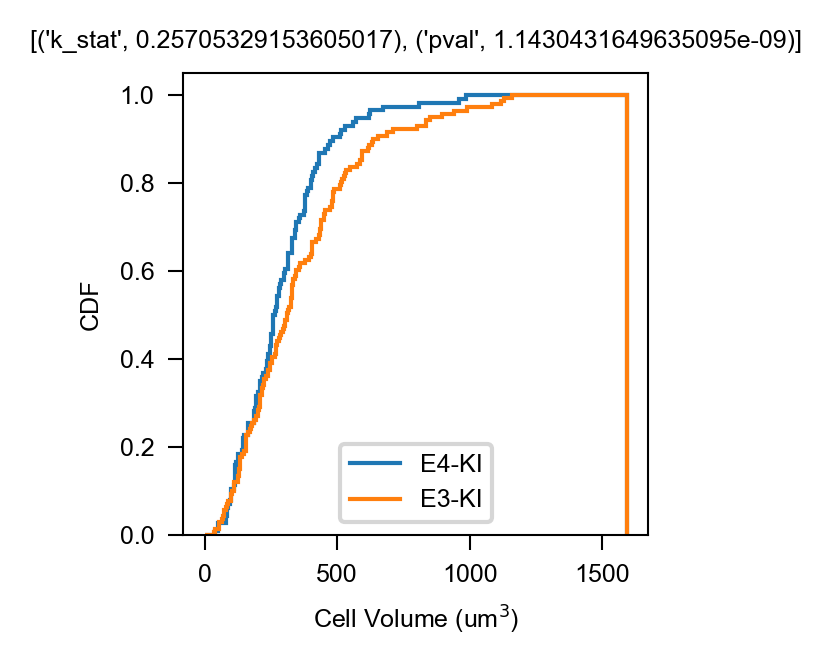

In [490]:
"""
GENOTYPE ONLY
"""


""" 5. Summarize in CDFs """
geno_types = ['E3' if 'E3' in t else 'E4' for t in my_tiffs]
ages = [ age_dict[ os.path.basename( t )] for t in my_tiffs]
ages = [str(a)+'mo' for a in ages]
geno_age = [f"{g}_{a}" for (g,a) in zip(geno_types,ages)]
tiffs_df = pd.DataFrame(
    {'tif':my_tiffs,
     'volumes':vols,
     'genotype':geno_types,
     'age':ages,
     'group_key':geno_types,
     'counts':[list() for t in my_tiffs],
     'cdf':[list() for t in my_tiffs],
     'bins':[list() for t in my_tiffs]
     }).set_index('tif')

vol_res = 5
bins = np.arange(0,1600,vol_res)
for t in tiffs_df.index:
    tiffs_df.at[t,'counts'] = np.histogram( tiffs_df.loc[t,'volumes'],bins=bins)[0]
    tiffs_df.at[t,'cdf'] = np.cumsum(tiffs_df.at[t,'counts'])/np.sum(tiffs_df.at[t,'counts'])
    tiffs_df.at[t,'bins'] = bins

stats_keys = list(set(tiffs_df['group_key']))
stats_df = pd.DataFrame({'group':stats_keys,
                         'volumes': [np.concatenate( tiffs_df['volumes'][tiffs_df['group_key']==s].values) for s in stats_keys],
                         'counts':[list() for s in stats_keys],
                         'cdf':[list() for s in stats_keys],
                         }).set_index('group')
for group in stats_df.index:
    stats_df.at[group,'counts'] = np.histogram( stats_df.loc[group,'volumes'],bins=bins)[0]
    stats_df.at[group,'cdf'] = np.cumsum(stats_df.at[group,'counts'])/np.sum(stats_df.at[group,'counts'])


""" 6. KS-Test GENO ONLY"""
g1 = 'E3'
g2 = 'E4'
k_stat, pval = sci.stats.ks_2samp( stats_df.loc[g1,'cdf'],stats_df.loc[g2,'cdf'] )
result = {'k_stat':k_stat,'pval':pval}
print(result)

fig_cdfs_geno_only,ax =plt.subplots(1,figsize=(2,2))
for g in stats_df.index:
    ax.stairs(stats_df.loc[g,'cdf'],bins,label=g+'-KI')
ax.set_ylabel('CDF')
ax.set_xlabel('Cell Volume (um$^3$)')
ax.set_title([ (k,v) for (k,v) in result.items()])
ax.legend()

fig_cdfs_geno_only.savefig('fig_cdfs_geno_only.svg')
stats_df.to_csv('Volumes_and_CDFS_Genotype_Only.csv')

{'k_stat': 0.2852664576802508, 'pval': 7.715616722864287e-12}
{'k_stat': 0.23197492163009403, 'pval': 6.159157081027812e-08}


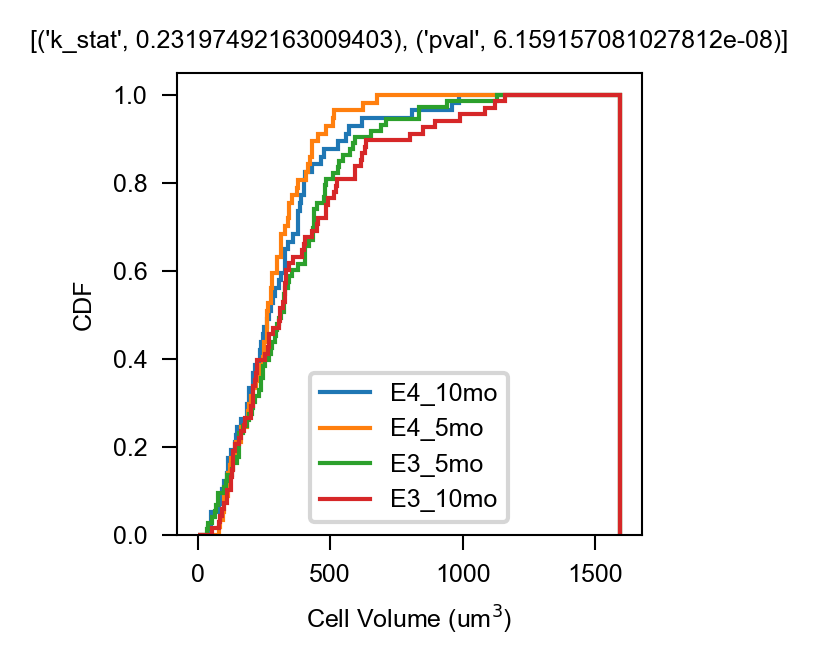

In [441]:
"""
GENOTYPE ONLY
"""


""" 5. Summarize in CDFs """
geno_types = ['E3' if 'E3' in t else 'E4' for t in my_tiffs]
ages = [ age_dict[ os.path.basename( t )] for t in my_tiffs]
ages = [str(a)+'mo' for a in ages]
geno_age = [f"{g}_{a}" for (g,a) in zip(geno_types,ages)]
tiffs_df = pd.DataFrame(
    {'tif':my_tiffs,
     'volumes':vols,
     'genotype':geno_types,
     'age':ages,
     'group_key':geno_age,
     'counts':[list() for t in my_tiffs],
     'cdf':[list() for t in my_tiffs],
     'bins':[list() for t in my_tiffs]
     }).set_index('tif')

vol_res = 5
bins = np.arange(0,1600,vol_res)
for t in tiffs_df.index:
    tiffs_df.at[t,'counts'] = np.histogram( tiffs_df.loc[t,'volumes'],bins=bins)[0]
    tiffs_df.at[t,'cdf'] = np.cumsum(tiffs_df.at[t,'counts'])/np.sum(tiffs_df.at[t,'counts'])
    tiffs_df.at[t,'bins'] = bins

stats_keys = list(set(tiffs_df['group_key']))
stats_df = pd.DataFrame({'group':stats_keys,
                         'volumes': [np.concatenate( tiffs_df['volumes'][tiffs_df['group_key']==s].values) for s in stats_keys],
                         'counts':[list() for s in stats_keys],
                         'cdf':[list() for s in stats_keys],
                         }).set_index('group')
for group in stats_df.index:
    stats_df.at[group,'counts'] = np.histogram( stats_df.loc[group,'volumes'],bins=bins)[0]
    stats_df.at[group,'cdf'] = np.cumsum(stats_df.at[group,'counts'])/np.sum(stats_df.at[group,'counts'])


""" 6. KS-Test 5mo"""
g1 = 'E3_5mo'
g2 = 'E4_5mo'
k_stat, pval = sci.stats.ks_2samp( stats_df.loc[g1,'cdf'],stats_df.loc[g2,'cdf'] )
result = {'k_stat':k_stat,'pval':pval}
print(result)


""" 6. KS-Test 10mo"""
g1 = 'E3_10mo'
g2 = 'E4_10mo'
k_stat, pval = sci.stats.ks_2samp( stats_df.loc[g1,'cdf'],stats_df.loc[g2,'cdf'] )
result = {'k_stat':k_stat,'pval':pval}
print(result)

fig_cdfs_geno,ax =plt.subplots(1,figsize=(2,2))
for g in stats_df.index:
    ax.stairs(stats_df.loc[g,'cdf'],bins,label=g)
ax.set_ylabel('CDF')
ax.set_xlabel('Cell Volume (um$^3$)')
ax.set_title([ (k,v) for (k,v) in result.items()])
ax.legend()


fig_cdfs_geno.savefig('fig_cdfs_geno-age.svg')
stats_df.to_csv('Volumes_and_CDFS_Genotype-Age.csv')

In [300]:
""" 5. Summarize in CDFs """
geno_types = [os.path.splitext(os.path.basename(curr_tif))[0]
ages = [ age_dict[ os.path.basename( t )] for t in my_tiffs]
geno_age = [f"{g}_{a}" for g,a in zip(geno_types,ages)]
groups_df = pd.DataFrame(
    {'tif':my_tiffs,
     'volumes':vols,
     'genotype':geno_types,
     'age':ages,
     'geno_age':geno_age,
     }).set_index('tif')


display(groups_df)

""" 6. KS-Test """
""" 6. KS-Test """
""" 7. Permutation Test """

,sizes_px,sizes_um3,feret_d,feret_z,feret_x,feret_y,min_fer,box_vol,pct_fill
ids,,,,,,,,,
70,31,2.452149,"[0.5, 11.5346804, 7.954952]",0.5,11.534680,7.954952,0.5,45.878914,0.053448
71,12855,1016.850768,"[7.5, 22.2738656, 24.2626036]",7.5,22.273866,24.262604,7.5,4053.164788,0.250878
72,13221,1045.801945,"[9.5, 15.1144088, 25.0580988]",9.5,15.114409,25.058099,9.5,3598.014316,0.290661
73,7699,609.003039,"[7.0, 11.932428, 13.921166]",7.0,11.932428,13.921166,7.0,1162.793177,0.523741
74,506,40.025398,"[1.0, 7.954952, 9.148194799999999]",1.0,7.954952,9.148195,1.0,72.773451,0.550000
